# Sentiment Analysis do Twitter Sem Feature Enginieering

## Carregar bibliotecas

In [1]:
import random, itertools
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from textblob import TextBlob
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression


from IPython.display import clear_output
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Gensim
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

## Carregar dados

In [2]:
dataset_semeval = pd.read_csv('datasets/SemEval2013_task2/allTrainingData.tsv',delimiter='\t',names=['id','token','sentiment','text'])
dataset_semeval.head()

,id,token,sentiment,text
0,264183816548130816,15140428,positive,Gas by my house hit $3.39!!!! I'm going to Cha...
1,264249301910310912,18516728,negative,Iranian general says Israel's Iron Dome can't ...
2,264105751826538497,147088367,positive,with J Davlar 11th. Main rivals are team Polan...
3,264094586689953794,332474633,negative,"Talking about ACT's &amp;&amp; SAT's, deciding..."
4,254941790757601280,557103111,negative,"They may have a SuperBowl in Dallas, but Dalla..."


### Eliminar Colunas não utilizadas

In [3]:
dataset_semeval = dataset_semeval.loc[:,['text','sentiment']]
dataset_semeval.head()

,text,sentiment
0,Gas by my house hit $3.39!!!! I'm going to Cha...,positive
1,Iranian general says Israel's Iron Dome can't ...,negative
2,with J Davlar 11th. Main rivals are team Polan...,positive
3,"Talking about ACT's &amp;&amp; SAT's, deciding...",negative
4,"They may have a SuperBowl in Dallas, but Dalla...",negative


### Mostrar labels únicas

In [4]:
print(list(set(dataset_semeval['sentiment'])))

['objective-OR-neutral', 'positive', 'negative', 'objective', 'neutral']


### Converter 'objective-OR-neutral' e 'objective' em 'neutral'

In [5]:
dataset_semeval.loc[dataset_semeval[dataset_semeval.loc[:,'sentiment'] == 'objective-OR-neutral'].index,'sentiment'] = 'neutral'
dataset_semeval.loc[dataset_semeval[dataset_semeval.loc[:,'sentiment'] == 'objective'].index,'sentiment'] = 'neutral'

# Mostrar labels únicas
print(list(set(dataset_semeval['sentiment'])))

['neutral', 'positive', 'negative']


### Distriuição de sentimentos

In [6]:
qtde_positive = sum(dataset_semeval.loc[:,'sentiment'] == 'positive')
qtde_neutral = sum(dataset_semeval.loc[:,'sentiment'] == 'neutral')
qtde_negative = sum(dataset_semeval.loc[:,'sentiment'] == 'negative')
total = dataset_semeval.shape[0]

print('Distribuição de Sentimentos:')
print('Total:\t\t',total,'\t100,00%')
print('Positivos:\t',qtde_positive,'\t',str(round(qtde_positive/total*100,2))+'%')
print('Neutros:\t',qtde_neutral,'\t',str(round(qtde_neutral/total*100,2))+'%')
print('Negativos:\t',qtde_negative,'\t',str(round(qtde_negative/total*100,2))+'%')

Distribuição de Sentimentos:
Total:		 8002 	100,00%
Positivos:	 2974 	 37.17%
Neutros:	 3869 	 48.35%
Negativos:	 1159 	 14.48%


# Separar os Conjuntos de Treinamento e Validação

In [7]:
X = dataset_semeval['text']
y = dataset_semeval['sentiment']

y.iloc[y[y == 'positive'].index] = 1
y.iloc[y[y == 'neutral'].index] = 0
y.iloc[y[y == 'negative'].index] = -1

classes = {
    1: 'positive',
    0: 'neutral',
    -1: 'negative'
}

In [8]:
X_temp, X_test, Y_temp, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, Y_temp, test_size=0.25, random_state=42)

# 2. Abordagem Lexicon

## 2.1 Definir as Funções

In [9]:
def get_polaridade(strings):
    polaridade = list()
    for item in strings:
        blob = TextBlob(item)
        polaridade.append(blob.sentiment.polarity)
        
    return polaridade

In [10]:
def classificar_por_polaridade(pol,mid,threshold=0):
    if pol < threshold+mid and pol > threshold-mid :
        return 0
    else:
        if pol > threshold:
            return 1
        else:
            return -1

## 2.2 Definir Parametros a partir do Conjunto de Treinamento
Parâmetros:

    Threshold - Determina no limite pelo qual o texto passa a ser considerado positivo ou negativo
    
    Mid - Determina o intervalo pelo qual o texto passa a ser considerao neutro ou polar

## 2.3 Descobrir melhor combinação de parâmetros

In [11]:
# Define os parametos
mids = np.linspace(0.1,0.9,30)
mids = [round(mid,2) for mid in mids]
mids = list(set(mids))

thresholds = np.linspace(-0.5,0.5,30)
thresholds = [round(threshold,2) for threshold in thresholds]
thresholds = list(set(thresholds))

fscore_threshold_list = list()

# Get polaridade
polaridade = get_polaridade(X_train.values)

for threshold in thresholds:
    
    fscore_mid_list = list()
    
    for mid in mids:
        classificacao = list()
        
        for item in polaridade:
            classificacao.append(classificar_por_polaridade(item,mid,threshold))
        classificacao = np.array(classificacao)

        fscore = f1_score(list(y_train.values),classificacao,average='micro')

        fscore_mid_list.append(fscore)
        
    fscore_threshold_list.append(fscore_mid_list)

# Busca os melhores resultados
best_threshold_index = None
best_mid_index = None

best_value = 0

for i,lista in enumerate(fscore_threshold_list):
    
    value = np.max(lista)
    if value > best_value:
        best_threshold_index = i
        best_mid_index = np.argmax(lista)
        best_value = value
        
# Imprime os resultados
print('Melhor Threshold:',thresholds[best_threshold_index],' - Melhor MID:',mids[best_mid_index],'- F1Score:', str(round(best_value*100,2))+'%')

Melhor Threshold: -0.09  - Melhor MID: 0.32 - F1Score: 61.89%


## 2.4 Desempenho no conjunto de validação

In [12]:
threshold = -0.09
mid = 0.32

polaridade = list()
for item in X_val.values:
    blob = TextBlob(item)
    polaridade.append(blob.sentiment.polarity)
    
classificacao = list()
for item in polaridade:
    classificacao.append(classificar_por_polaridade(item,mid,threshold))
classificacao = np.array(classificacao)

# F1Score
fscore = f1_score(list(y_val.values),classificacao,average='micro')
print('F1Score:',str(round(100*fscore,2))+'%')

F1Score: 64.89%


# 3. Abordagem com Aprendizado

## 3.1 Funções e Classes

In [13]:
class LabeledLineSentence(object):
    def __init__(self, sources):
        self.sources = sources
        self.count = 0
    
    def to_array(self):
        self.sentences = []
        for source, value in self.sources.items():
            prefix = value[0]
            data = value[1]
            for item_no, line in enumerate(data):
                self.sentences.append(TaggedDocument(utils.to_unicode(line).split(), [prefix + '_%s' % item_no]))
                self.count+=1
        return self.sentences
    
    def sentences_perm(self):
        shuffled = list(self.sentences)
        random.shuffle(shuffled)
        return shuffled

In [14]:
def train_model(sentences, features=10, window=5, min_count=1, epochs=10, sub_sample=1e-4, dm=0):
    
    #print('\nInitializating Doc2Vec...')

    # Init Model
    model = Doc2Vec(dm=dm, min_count=min_count, window=window, vector_size=features, sample=sub_sample, negative=5, workers=7)
    model.build_vocab(sentences.to_array())


    # Train Model

    # Measure Time
    from time import time
    
    #print('Training Doc2Vec...')

    # Start
    start = time()

    # Train
    model.train(sentences.sentences_perm(),total_examples=sentences.count,epochs=epochs)

    # End
    end = time()

    # Elapsed
    elapsed = end - start
    #print('Duration:',int(elapsed/60),'minutes and',int(elapsed%60),'seconds')
    
    return model

In [15]:
def print_score(clf, titulo, x_tr, y_tr):
    
    desempenho = calcula_desempenho_algoritmo(clf,x=x_tr,y=y_tr)

    print_resultados(titulo, desempenho)

In [16]:
def calcula_desempenho_algoritmo(modelo,x,y):
    resultados = dict()

    resultados = dict()

    modelo = modelo.fit(x,y)

    scores = cross_val_score(modelo, X, y, cv=10, scoring='accuracy', n_jobs=-1)

    resultados['mean'] = scores.mean()
    resultados['std'] = scores.std()
    resultados['modelo'] = modelo
        
    return resultados

In [17]:
def print_resultados(titulo,resultados):
    print('F1 Score ' + titulo +'\n')
    media = round(resultados['mean']*100,2)
    std = str(round(resultados['std']*100,2))
    print(str(media)+'% +-',std+'%')

In [18]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5),scoring=None):
    
    from sklearn.model_selection import learning_curve
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
       
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,scoring=scoring)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_mean = np.mean(test_scores, axis=1)
    
    test_scores_std = np.std(test_scores, axis=1)
    
    if ylim is not None:
        plt.ylim(*ylim)
    else:
        plt.ylim(round(min([np.min(train_scores),np.min(test_scores)]),2)-0.01,1.01)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [19]:
def split_data_for_gensim(train_pos_set, train_neg_set, train_neu_set, val_pos_set, val_neg_set, val_neu_set, features):
    
    fea = features
    
    #
    # Train Set
    #

    # Definr os paramtros 
    tam_pos = train_pos_set.shape[0]
    tam_neg = train_neg_set.shape[0]
    tam_neu = train_neu_set.shape[0]
    tam = tam_pos + tam_neg + tam_neu
    train_arrays = np.zeros((tam, fea))
    train_labels = np.zeros(tam)

    for i in range(tam_pos):
        # Define o prefixo
        prefix_train_pos = 'TRAIN_POS_' + str(i)
        train_arrays[i] = model.docvecs[prefix_train_pos]
        train_labels[i] = 2

    for i in range(tam_neg):
        prefix_train_neg = 'TRAIN_NEG_' + str(i)
        train_arrays[tam_pos + i] = model.docvecs[prefix_train_neg]
        train_labels[tam_pos + i] = 0

    for i in range(tam_neu):
        prefix_train_neu = 'TRAIN_NEU_' + str(i)
        train_arrays[tam_pos + tam_neg + i] = model.docvecs[prefix_train_neg]
        train_labels[tam_pos + tam_neg + i] = 1

    #
    # Validation Set
    #

    # Definr os paramtros
    tam_pos = val_pos_set.shape[0]
    tam_neg = val_neg_set.shape[0]
    tam_neu = val_neu_set.shape[0]
    tam = tam_pos + tam_neg + tam_neu
    val_arrays = np.zeros((tam, fea))
    val_labels = np.zeros(tam)

    for i in range(tam_pos):
        prefix_val_pos = 'VAL_POS_' + str(i)
        val_arrays[i] = model.docvecs[prefix_val_pos]
        val_labels[i] = 2

    for i in range(tam_neg):
        prefix_val_neg = 'VAL_NEG_' + str(i)
        val_arrays[tam_pos + i] = model.docvecs[prefix_val_neg]
        val_labels[tam_pos + i] = 0

    for i in range(tam_neu):
        prefix_val_neu = 'VAL_NEU_' + str(i)
        val_arrays[tam_pos + tam_neg + i] = model.docvecs[prefix_val_neu]
        val_labels[tam_pos + tam_neg + i] = 1
        
    return {
        'train': {
            'arrays': train_arrays,
            'labels': train_labels
        },
        'val': {
            'arrays': val_arrays,
            'labels': val_labels
        }
    }

## 3.2 Separar as fontes de dados

In [20]:
# Train Set
train_neg_set = X_train[y_train == -1]
train_neu_set = X_train[y_train == 0]
train_pos_set = X_train[y_train == 1]

# Validation Set
val_neg_set = X_val[y_val == -1]
val_neu_set = X_val[y_val == 0]
val_pos_set = X_val[y_val == 1]

# Test Set
test_neg_set = X_test[y_test == -1]
test_neu_set = X_test[y_test == 0]
test_pos_set = X_test[y_test == 1]

## 3.3 Definir as fontes de dados

In [21]:
sources = {
    'train-neg':('TRAIN_NEG',train_neg_set.values),
    'val-neg':('VAL_NEG',val_neg_set.values),
    'test-neg':('TEST_NEG',test_neg_set.values),
    
    'train-neu':('TRAIN_NEU',train_neu_set.values),
    'val-neu':('VAL_NEU',val_neu_set.values),
    'test-neu':('TEST_NEU',test_neu_set.values),
    
    'test-pos':('TEST_POS',test_pos_set.values),
    'val-pos':('VAL_POS',val_pos_set.values),
    'train-pos':('TRAIN_POS',train_pos_set.values),

}

sentences = LabeledLineSentence(sources)

## 3.4 Escolher Modelo Doc2Vec

In [22]:
# Train Parameters
#features = [5,10,20,40,80,120]
features = [4]
#window = [1,3,5,7,11,13,17]
window = [4]
#min_count = [1,2,3,4,5]
min_count = [3]
epochs = [10,20,30]
sub_sample = [1e-4]
dm = [1]
    
# Itera pelo produto cartesiano dos paramtros
results = dict()
iteration = 0
total_iterations = len(features)*len(window)*len(min_count)*len(epochs)*len(sub_sample)*len(dm)
best_score = 0
best_params = None
print('Completed:\t 0.00%')
print('Best Score:\t 0.00%')
for fw in itertools.product(features, window, min_count, epochs, sub_sample, dm):
    
    # Converter para inteiro
    fea = fw[0]
    win = fw[1]
    m_cnt = fw[2]
    epc = fw[3]
    sam = fw[4]
    d = fw[5]
    
    print('\nTrying... Feature:', fea,'Window:',win,'Min Count:',m_cnt, 'Epochs:',epc, 'Sampling:', sam, 'Dbow:',d)

    # Treina o modelo de acordo com as sentenças
    model = train_model(sentences, features=fea, window=win, min_count=m_cnt, epochs=epc, sub_sample=sam, dm=d)

    # Separar os dados de trainamento e validação
    dados = split_data_for_gensim(train_pos_set, train_neg_set, train_neu_set, val_pos_set, val_neg_set, val_neu_set, fea)
    train_arrays = dados['train']['arrays']
    train_labels = dados['train']['labels']
    val_arrays = dados['val']['arrays']
    val_labels = dados['val']['labels']


    # Scale Data
    scaler = preprocessing.StandardScaler().fit(train_arrays)
    train_arrays = scaler.transform(train_arrays)
    val_arrays = scaler.transform(val_arrays)

    classifier = LogisticRegression(n_jobs=-1)
    classifier.fit(train_arrays, train_labels)

    pred = classifier.predict(val_arrays)
    score = f1_score(val_labels, pred, average='micro')
    
    results[(fea,win,m_cnt,epc,sam,d)] = score
    
    #
    # Info
    #
    
    if score>best_score:
        best_score = score
        best_params=fw
    
    iteration +=1
    completed = str(round(iteration/total_iterations*100,2))+'%'
    
    clear_output(True)
    print('Completed:\t',completed)
    print('Best Score:\t',str(round(best_score*100,2))+'%')
    print('Best Params:\tFeatures:', best_params[0],'Window:',best_params[1],'Min Count:',best_params[2], 'Epochs:',best_params[3], 'Sampling:', best_params[4], 'Dbow:',best_params[5])

Completed:	 100.0%
Best Score:	 36.18%
Best Params:	Features: 4 Window: 4 Min Count: 3 Epochs: 10 Sampling: 0.0001 Dbow: 1


#### Best Params
Features: 4 Window: 4 Min Count: 3 Epochs: 20 Sampling: 0.0001 Dbow: 1

In [23]:
fea = 4
win = 4
m_cnt = 3
epc = 10
sam = 1e-4
d = 1

print('Doc2Vec - Feature:', fea,'Window:',win,'Min Count:',m_cnt, 'Epochs:',epc, 'Sampling:', sam, 'Dbow:',d)

# Treina o modelo de acordo com as sentenças
model = train_model(sentences, features=fea, window=win, min_count=m_cnt, epochs=epc, sub_sample=sam, dm=d)

# Separar os dados de trainamento e validação
dados = split_data_for_gensim(train_pos_set, train_neg_set, train_neu_set, val_pos_set, val_neg_set, val_neu_set, fea)
train_arrays = dados['train']['arrays']
train_labels = dados['train']['labels']
val_arrays = dados['val']['arrays']
val_labels = dados['val']['labels']


# Scale Data
scaler = preprocessing.StandardScaler().fit(train_arrays)
train_arrays = scaler.transform(train_arrays)
val_arrays = scaler.transform(val_arrays)

Doc2Vec - Feature: 4 Window: 4 Min Count: 3 Epochs: 10 Sampling: 0.0001 Dbow: 1


## Escolher modelo RandomForest utilizando Random Search

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


initial_tree = DecisionTreeClassifier()
initial_tree.fit(train_arrays, train_labels)
max_depth = [int(x) for x in np.linspace(2, initial_tree.tree_.max_depth, 60)]
max_depth.append(None)


model = RandomForestClassifier(n_jobs=-1)

parameters = {
    'n_estimators': [int(x) for x in np.linspace(10, 1000, 60)],
    'max_features': ['auto','log2', None],
    'max_depth': max_depth,
    'min_samples_split': [2,3,4,5,7,10],
    'min_samples_leaf': [1,2,3,4,5,7,10],
    
}

random_search = RandomizedSearchCV(model, parameters, n_jobs=-1, scoring='f1_micro', n_iter=60, cv=10)

random_search.fit(train_arrays, train_labels)

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=60, n_jobs=-1,
          param_distributions={'n_estimators': [10, 26, 43, 60, 77, 93, 110, 127, 144, 161, 177, 194, 211, 228, 244, 261, 278, 295, 312, 328, 345, 362, 379, 395, 412, 429, 446, 463, 479, 496, 513, 530, 546, 563, 580, 597, 614, 630, 647, 664, 681, 697, 714, 731, 748, 765, 781, 798, 815, 832, 848, 865, 882, 899...30, 31, None], 'min_samples_split': [2, 3, 4, 5, 7, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 7, 10]},
          pre_dispatch='2*n_jobs', r

In [25]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=379, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Mostrar Curva de Aprendizado

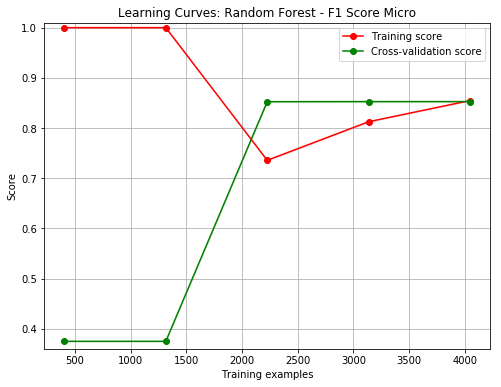

In [27]:
title = "Learning Curves: Random Forest - F1 Score Micro"

plt = plot_learning_curve(random_search.best_estimator_, title, train_arrays, train_labels, cv=10, n_jobs=-1,scoring='f1_micro')
plt.show()